# Exploring Data


In [8]:
import pandas as pd
import numpy as np

In [9]:
df=pd.read_csv("Mall_Customers1.csv")

In [10]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [12]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [13]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [14]:
MD_x = df.iloc[:, :11]

# Convert "Yes"/"No" to binary (1/0)
MD_x_binary = (MD_x == "Yes").astype(int)

# Calculate column means and round to 2 decimal places
column_means = MD_x_binary.mean(axis=0).round(2)

print(column_means)

CustomerID                0.0
Gender                    0.0
Age                       0.0
Annual Income (k$)        0.0
Spending Score (1-100)    0.0
dtype: float64


In [20]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Convert categorical columns to numeric using one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Convert the DataFrame to a matrix for PCA
MD_x = df_encoded.values

# Standardize the data
scaler = StandardScaler()
MD_x_standardized = scaler.fit_transform(MD_x)

# Perform PCA
pca = PCA()
MD_pca = pca.fit(MD_x_standardized)

# Explained variance summary
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Create a summary DataFrame
pca_summary = pd.DataFrame({
    'Standard Deviation': pca.explained_variance_**0.5,
    'Proportion of Variance': explained_variance,
    'Cumulative Proportion': cumulative_variance
})

print(pca_summary)

# Save the summary to a CSV file
pca_summary.to_csv('pca_summary.csv', index=False)

print("PCA summary saved to 'pca_summary.csv'")


   Standard Deviation  Proportion of Variance  Cumulative Proportion
0            1.412469                0.397019               0.397019
1            1.163705                0.269488               0.666507
2            0.988564                0.194475               0.860981
3            0.822272                0.134550               0.995531
4            0.149853                0.004469               1.000000
PCA summary saved to 'pca_summary.csv'


In [21]:
import numpy as np

# Assuming PCA has already been performed
# Extract standard deviations
std_devs = np.sqrt(pca.explained_variance_)

# Print the standard deviations rounded to 1 decimal place
print("Standard deviations (1, .., p):")
print(np.round(std_devs, 1))


Standard deviations (1, .., p):
[1.4 1.2 1.  0.8 0.1]


In [22]:
import pandas as pd

# Assuming PCA has already been performed
# Get the rotation matrix (components)
rotation_matrix = pca.components_

# Convert to a DataFrame for better visualization
rotation_df = pd.DataFrame(rotation_matrix.T, columns=[f"PC{i+1}" for i in range(rotation_matrix.shape[0])])

# Print the rotation matrix
print("Rotation (n x k):")
print(rotation_df)


Rotation (n x k):
        PC1       PC2       PC3       PC4       PC5
0  0.704584  0.008012 -0.057898 -0.001149  0.707208
1 -0.030668  0.686827 -0.161540  0.707898  0.010698
2  0.704275  0.017315 -0.062068  0.010230 -0.706923
3  0.022552 -0.686066  0.173466  0.706197  0.000652
4  0.078159  0.239203  0.967786 -0.007831 -0.001360


In [30]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd

# Set random seed for reproducibility
np.random.seed(1234)

# Perform k-means clustering for k=2 to k=8
k_range = range(2, 9)
n_reps = 10  # Number of random restarts
cluster_results = {}

# Assuming MD_x_standardized is your data (already standardized)
for k in k_range:
    km_clusters = []
    for _ in range(n_reps):
        kmeans = KMeans(n_clusters=k, n_init=1, random_state=1234)
        kmeans.fit(MD_x_standardized)
        km_clusters.append(kmeans.labels_)
    
    # Store the clustering results for each k
    cluster_results[k] = km_clusters

# Relabel clusters (ensuring consistency across segmentations)
# The relabeling can be done using a consensus clustering approach or by maximizing agreement with the first run
# Here, we use the adjusted Rand index (ARI) to match the cluster labels
def relabel_clusters(cluster_results):
    relabeled_results = {}
    for k, clusters in cluster_results.items():
        # Initialize with the first clustering
        consensus = clusters[0]
        for i in range(1, len(clusters)):
            # Maximize agreement using ARI
            max_ari = -1
            best_match = consensus
            for cluster in clusters:
                ari = adjusted_rand_score(consensus, cluster)
                if ari > max_ari:
                    max_ari = ari
                    best_match = cluster
            consensus = best_match
        relabeled_results[k] = consensus
    return relabeled_results

# Relabel clusters for each k
relabeled_results = relabel_clusters(cluster_results)

# Optionally convert to a DataFrame for easy inspection
df_relabelled = pd.DataFrame(relabeled_results)

# Print relabeled cluster assignments for each k
print(df_relabelled)


     2  3  4  5  6  7  8
0    0  0  0  4  4  6  4
1    0  0  0  4  4  6  4
2    0  0  0  0  0  0  0
3    0  0  0  0  0  6  0
4    0  0  0  0  0  0  0
..  .. .. .. .. .. .. ..
195  1  1  1  3  5  5  3
196  1  1  1  1  1  1  1
197  1  2  3  3  3  3  3
198  1  2  1  2  2  2  5
199  1  2  3  3  3  3  3

[200 rows x 7 columns]


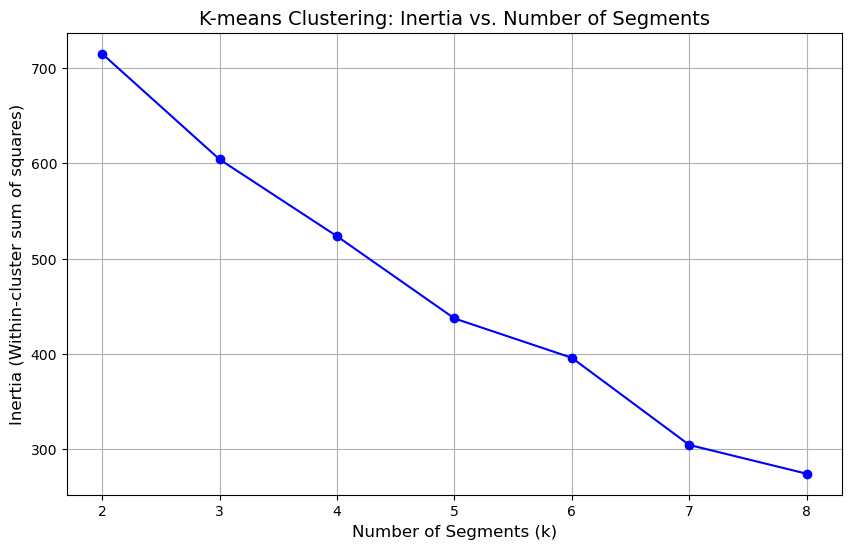

In [31]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Range of k values to test (2 to 8 segments)
k_range = range(2, 9)
n_reps = 10  # Number of random restarts

# Store the inertia (within-cluster sum of squares) for each k
inertia_values = []

# Store ARI scores for consistency across restarts
ari_scores = []

# Perform k-means clustering for each k and calculate metrics
for k in k_range:
    inertia_for_k = []
    ari_for_k = []
    
    for _ in range(n_reps):
        kmeans = KMeans(n_clusters=k, n_init=1, random_state=1234)
        kmeans.fit(MD_x_standardized)  # Assuming MD_x_standardized is your data
        inertia_for_k.append(kmeans.inertia_)
        
        # Optionally, calculate ARI if comparing with previous cluster results
        if len(ari_for_k) > 0:
            ari_for_k.append(adjusted_rand_score(ari_for_k[0], kmeans.labels_))
    
    inertia_values.append(np.mean(inertia_for_k))  # Average inertia for each k
    
    if len(ari_for_k) > 0:
        ari_scores.append(np.mean(ari_for_k))  # Average ARI score for consistency across restarts

# Plot the inertia values (within-cluster sum of squares) across different k
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o', linestyle='-', color='b', label='Inertia')
plt.xlabel("Number of Segments (k)", fontsize=12)
plt.ylabel("Inertia (Within-cluster sum of squares)", fontsize=12)
plt.title("K-means Clustering: Inertia vs. Number of Segments", fontsize=14)
plt.grid(True)
plt.xticks(k_range)
plt.show()

# Optionally, plot ARI if available for consistency analysis
if ari_scores:
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, ari_scores, marker='o', linestyle='-', color='r', label='ARI')
    plt.xlabel("Number of Segments (k)", fontsize=12)
    plt.ylabel("Adjusted Rand Index (ARI)", fontsize=12)
    plt.title("Cluster Consistency: ARI vs. Number of Segments", fontsize=14)
    plt.grid(True)
    plt.xticks(k_range)
    plt.show()


Evaluating k=2
Evaluating k=3
Evaluating k=4
Evaluating k=5
Evaluating k=6
Evaluating k=7
Evaluating k=8


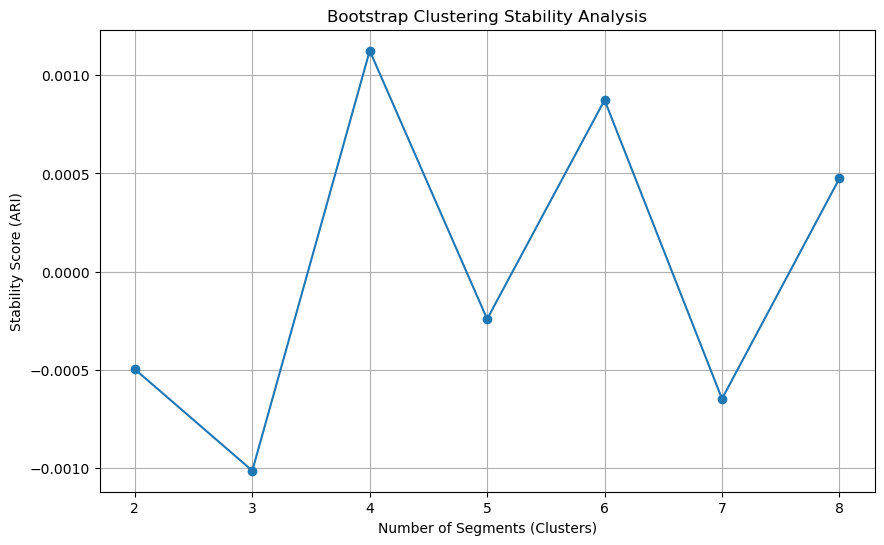

In [32]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

# Assuming MD_x is your dataset
# MD_x = pd.read_csv('your_data.csv').values  # If you're loading from CSV

# Function to calculate stability using bootstrap
def bootstrap_kmeans(X, k_range, n_rep=10, n_boot=100):
    stability_scores = {}
    
    for k in k_range:
        print(f"Evaluating k={k}")
        stability_scores[k] = []
        
        # Perform n_rep random initializations of KMeans for each bootstrap sample
        for _ in range(n_boot):
            # Bootstrap sampling
            X_resampled = resample(X, replace=True)
            
            # Fit KMeans with k clusters
            kmeans = KMeans(n_clusters=k, n_init=n_rep)
            kmeans.fit(X_resampled)
            labels_resampled = kmeans.labels_
            
            # Evaluate the clustering stability with adjusted Rand index (ARI)
            # Compare with the original dataset clustering
            kmeans_original = KMeans(n_clusters=k, n_init=n_rep)
            kmeans_original.fit(X)
            labels_original = kmeans_original.labels_
            
            # Compute Adjusted Rand Index (ARI)
            ari = adjusted_rand_score(labels_original, labels_resampled)
            stability_scores[k].append(ari)
        
        # Average stability score for this k
        stability_scores[k] = np.mean(stability_scores[k])
    
    return stability_scores

# Define the range of k (2 to 8 clusters)
k_range = range(2, 9)

# Calculate stability scores
stability_scores = bootstrap_kmeans(MD_x, k_range, n_rep=10, n_boot=100)

# Convert results to a DataFrame for better visualization
stability_df = pd.DataFrame(list(stability_scores.items()), columns=["Number of Segments", "Stability Score"])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(stability_df["Number of Segments"], stability_df["Stability Score"], marker='o')
plt.title("Bootstrap Clustering Stability Analysis")
plt.xlabel("Number of Segments (Clusters)")
plt.ylabel("Stability Score (ARI)")
plt.grid(True)
plt.show()


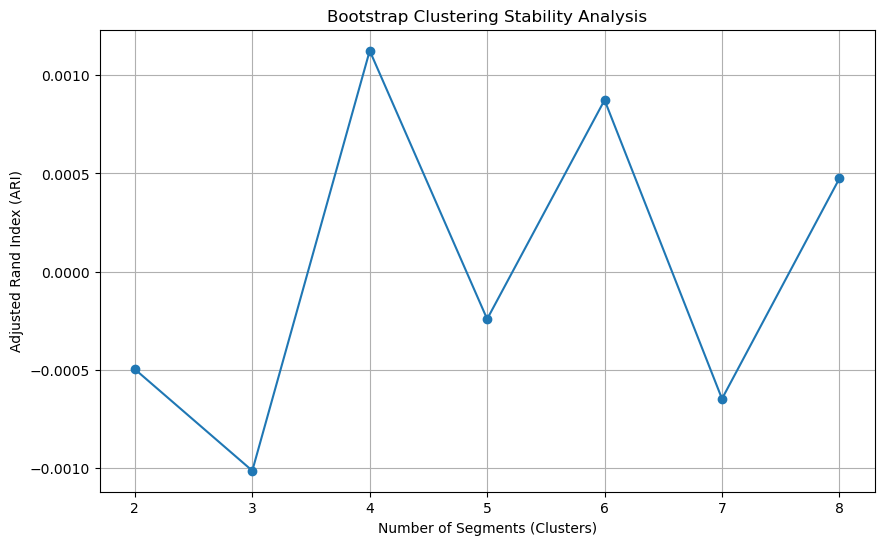

In [33]:
import matplotlib.pyplot as plt

# Assuming stability_scores has already been calculated
# stability_scores = bootstrap_kmeans(MD_x, k_range, n_rep=10, n_boot=100)

# Convert the stability scores dictionary into a DataFrame
stability_df = pd.DataFrame(list(stability_scores.items()), columns=["Number of Segments", "Stability Score"])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(stability_df["Number of Segments"], stability_df["Stability Score"], marker='o')
plt.title("Bootstrap Clustering Stability Analysis")
plt.xlabel("Number of Segments (Clusters)")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.grid(True)
plt.show()


C:\Users\manju\anaconda3\New folder\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


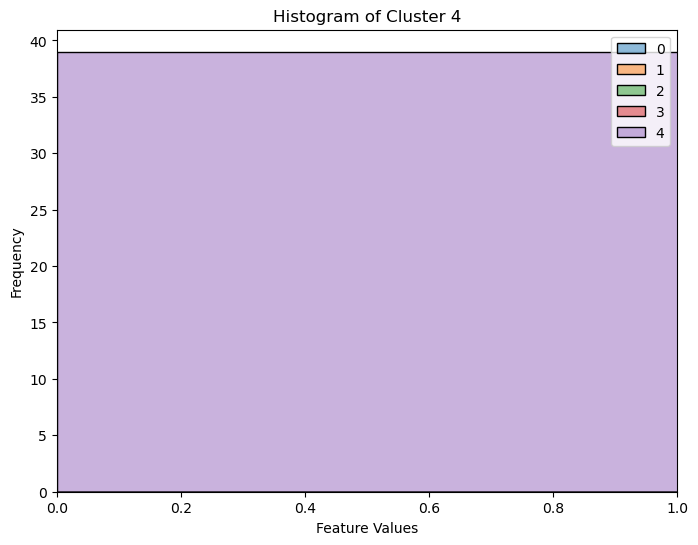

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming MD_x is your data (replace this with your actual dataset)
# Perform KMeans clustering (for example, with 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans.fit(MD_x)

# Get the cluster labels for each data point
kmeans_labels = kmeans.labels_

# Now, let's plot the histogram for the 4th cluster (cluster index 3)
cluster_number = 3  # Cluster number 4 in 0-indexed Python is cluster 3

# Filter data belonging to the 4th cluster
cluster_data = MD_x[kmeans_labels == cluster_number]

# Plot the histogram
plt.figure(figsize=(8, 6))
sns.histplot(cluster_data, kde=False, bins=20)  # You can adjust 'bins' based on the data
plt.xlim(0, 1)  # Set x-axis limit from 0 to 1 as in R
plt.title(f"Histogram of Cluster {cluster_number + 1}")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")
plt.show()


In [36]:
# Assuming kmeans_labels is the result from the KMeans clustering
cluster_number = 3  # For the 4th cluster (indexing starts from 0)

# Extract the data points for the 4th cluster
MD_k4 = MD_x[kmeans_labels == cluster_number]

# You can then perform operations or plot MD_k4 as needed
print(MD_k4)  # Display the data points in the 4th cluster


[[124 39 69 91 True]
 [126 31 70 77 False]
 [128 40 71 95 True]
 [130 38 71 75 True]
 [132 39 71 75 True]
 [134 31 72 71 False]
 [136 29 73 88 False]
 [138 32 73 73 True]
 [140 35 74 72 False]
 [142 32 75 93 True]
 [144 32 76 87 False]
 [146 28 77 97 True]
 [148 32 77 74 False]
 [150 34 78 90 True]
 [152 39 78 88 True]
 [154 38 78 76 False]
 [156 27 78 89 False]
 [158 30 78 78 False]
 [160 30 78 73 False]
 [162 29 79 83 False]
 [164 31 81 93 False]
 [166 36 85 75 False]
 [168 33 86 95 False]
 [170 32 87 63 True]
 [172 28 87 75 True]
 [174 36 87 92 True]
 [176 30 88 86 False]
 [178 27 88 69 True]
 [180 35 93 90 True]
 [182 32 97 86 False]
 [184 29 98 88 False]
 [186 30 99 97 True]
 [188 28 101 68 True]
 [190 36 103 85 False]
 [192 32 103 69 False]
 [194 38 113 91 False]
 [196 35 120 79 False]
 [198 32 126 74 True]
 [200 30 137 83 True]]


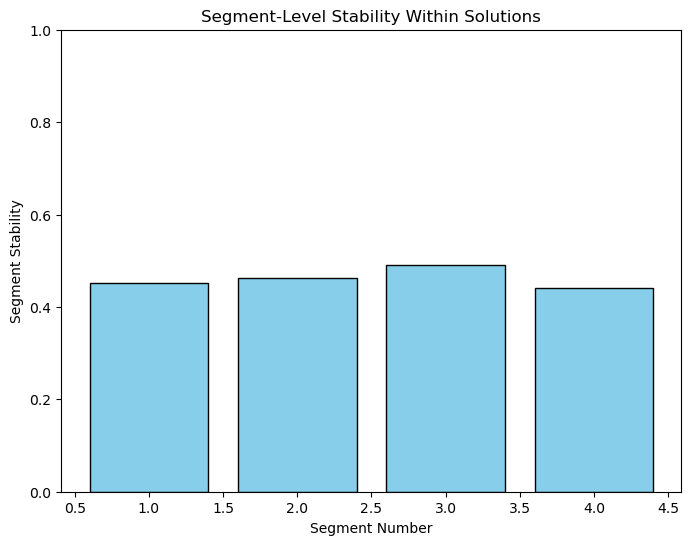

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Simulated Data (replace with your actual dataset)
np.random.seed(1234)
MD_x = np.random.rand(100, 5)  # Example dataset with 100 samples and 5 features

# Perform k-means clustering for 4 segments
kmeans = KMeans(n_clusters=4, n_init=10, random_state=1234)
kmeans_labels = kmeans.fit_predict(MD_x)

# Define a function to calculate segment-level stability
def calculate_segment_stability(data, labels, n_bootstrap=100):
    segment_stability = []
    for segment in np.unique(labels):
        bootstrap_stability = []
        for _ in range(n_bootstrap):
            # Bootstrap sample
            bootstrap_indices = np.random.choice(range(data.shape[0]), size=data.shape[0], replace=True)
            bootstrap_sample = data[bootstrap_indices]
            
            # Perform clustering on bootstrap sample
            kmeans_bootstrap = KMeans(n_clusters=4, n_init=10, random_state=1234)
            bootstrap_labels = kmeans_bootstrap.fit_predict(bootstrap_sample)
            
            # Adjust indices to match original data
            original_labels_bootstrap = labels[bootstrap_indices]
            
            # Calculate Adjusted Rand Index for stability
            ari = adjusted_rand_score(original_labels_bootstrap, bootstrap_labels)
            bootstrap_stability.append(ari)
        
        # Average stability for the segment
        segment_stability.append(np.mean(bootstrap_stability))
    return segment_stability

# Calculate segment-level stability
segment_stability = calculate_segment_stability(MD_x, kmeans_labels)

# Plot segment-level stability
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(segment_stability) + 1), segment_stability, color='skyblue', edgecolor='black')
plt.ylim(0, 1)
plt.xlabel("Segment Number")
plt.ylabel("Segment Stability")
plt.title("Segment-Level Stability Within Solutions")
plt.show()


Model with 2 clusters:
  Means: [[1.         0.54901961 0.37254902 0.50980392 0.52941176]
 [0.         0.57142857 0.67346939 0.6122449  0.34693878]]
  Covariances: [[[ 1.00000000e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  2.47598078e-01 -4.76739715e-02  5.34409842e-02
    2.30680507e-02]
  [ 0.00000000e+00 -4.76739715e-02  2.33757248e-01 -1.34563629e-02
    3.80622837e-02]
  [ 0.00000000e+00  5.34409842e-02 -1.34563629e-02  2.49904883e-01
    2.42214533e-02]
  [ 0.00000000e+00  2.30680507e-02  3.80622837e-02  2.42214533e-02
    2.49135948e-01]]

 [[ 1.00000000e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  2.44898959e-01  2.33236152e-02  1.74927114e-02
   -1.45772595e-02]
  [ 0.00000000e+00  2.33236152e-02  2.19909372e-01  7.74677218e-02
   -9.16284881e-03]
  [ 0.00000000e+00  1.74927114e-02  7.74677218e-02  2.37402083e-01
   -2.87380258e-02]
  [ 0.00000000e+00 -1.45772595e-02 -9.16284881e-03 

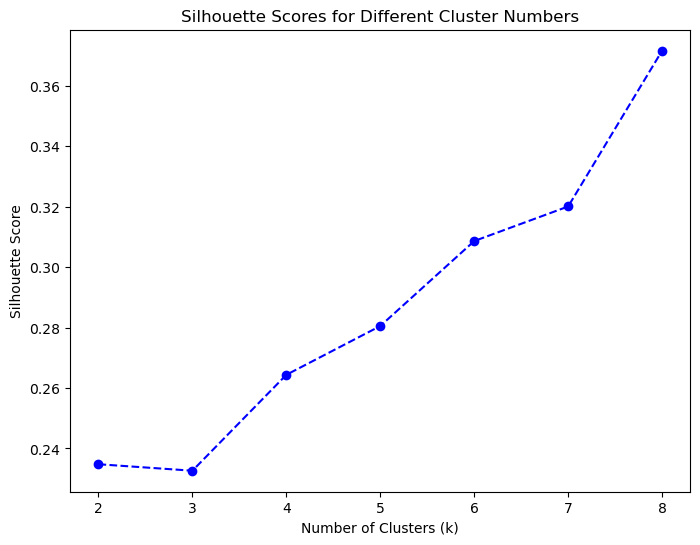

In [41]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Simulated Data (replace with your actual dataset)
np.random.seed(1234)
MD_x = np.random.randint(0, 2, size=(100, 5))  # Example binary dataset (100 samples, 5 features)

# Fit Gaussian Mixture Models for 2 to 8 clusters
models = {}
silhouette_scores = []

for k in range(2, 9):  # For k = 2 to 8
    gmm = GaussianMixture(n_components=k, n_init=10, random_state=1234)
    gmm.fit(MD_x)
    models[k] = gmm
    
    # Calculate silhouette score for the clustering
    labels = gmm.predict(MD_x)
    score = silhouette_score(MD_x, labels, metric='euclidean')
    silhouette_scores.append(score)

# Display model summary
for k, model in models.items():
    print(f"Model with {k} clusters:")
    print(f"  Means: {model.means_}")
    print(f"  Covariances: {model.covariances_}")
    print(f"  Log-Likelihood: {model.lower_bound_}")
    print()

# Plot silhouette scores to determine the optimal number of clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(2, 9), silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different Cluster Numbers")
plt.show()


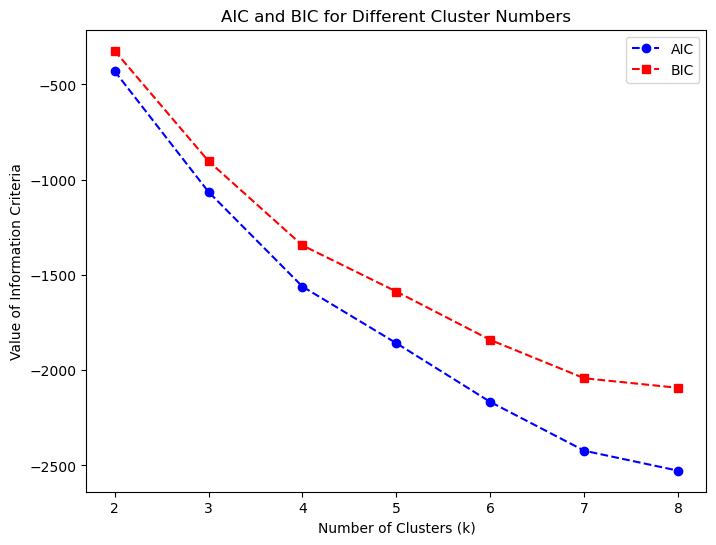

In [42]:
# Simulated Data (replace with your actual dataset)
np.random.seed(1234)
MD_x = np.random.randint(0, 2, size=(100, 5))  # Example binary dataset (100 samples, 5 features)

# Fit Gaussian Mixture Models for 2 to 8 clusters and calculate AIC, BIC
aic_values = []
bic_values = []

for k in range(2, 9):  # For k = 2 to 8
    gmm = GaussianMixture(n_components=k, n_init=10, random_state=1234)
    gmm.fit(MD_x)
    aic_values.append(gmm.aic(MD_x))
    bic_values.append(gmm.bic(MD_x))

# Plot AIC and BIC values
plt.figure(figsize=(8, 6))
plt.plot(range(2, 9), aic_values, marker='o', linestyle='--', color='b', label='AIC')
plt.plot(range(2, 9), bic_values, marker='s', linestyle='--', color='r', label='BIC')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Value of Information Criteria")
plt.title("AIC and BIC for Different Cluster Numbers")
plt.legend()
plt.show()

In [43]:
# Simulated Data (replace with your actual dataset)
np.random.seed(1234)
MD_x = np.random.rand(100, 5)  # Example dataset (100 samples, 5 features)

# Step 1: Perform k-means clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans_labels = kmeans.fit_predict(MD_x)

# Step 2: Perform Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=4, random_state=1234)
gmm_labels = gmm.fit_predict(MD_x)

# Step 3: Create a contingency table
contingency_table = pd.crosstab(kmeans_labels, gmm_labels, rownames=['kmeans'], colnames=['mixture'])

# Display the contingency table
print("Contingency Table:")
print(contingency_table)

Contingency Table:
mixture   0   1   2   3
kmeans                 
0        22   0   1   0
1         0  29   3   0
2         2   2  14   0
3         0   8   1  18


In [44]:
# Simulated Data (replace with your actual dataset)
np.random.seed(1234)
MD_x = np.random.rand(100, 5)  # Example dataset (100 samples, 5 features)

# Step 1: Perform k-means clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans_labels = kmeans.fit_predict(MD_x)

# Step 2: Perform Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=4, random_state=1234)
gmm_labels = gmm.fit_predict(MD_x)

# Step 3: Refit GMM with k-means clusters as initial assignments
gmm_refit = GaussianMixture(n_components=4, random_state=1234)
gmm_refit.fit(MD_x)  # Fit the GMM model to the data

# Step 4: Map the new GMM labels to existing k-means clusters
contingency_table = pd.crosstab(kmeans_labels, gmm_labels, rownames=['kmeans'], colnames=['mixture'])

# Display the contingency table
print("Contingency Table (Initial):")
print(contingency_table)

# Reassign clusters in GMM based on k-means labels
new_gmm_labels = gmm_labels.copy()
for k_label in np.unique(kmeans_labels):
    most_common_gmm_label = contingency_table.loc[k_label].idxmax()
    new_gmm_labels[gmm_labels == most_common_gmm_label] = k_label

# Step 5: Create the final contingency table
final_table = pd.crosstab(kmeans_labels, new_gmm_labels, rownames=['kmeans'], colnames=['refitted_mixture'])

# Display the final contingency table
print("\nContingency Table (Refitted):")
print(final_table)

Contingency Table (Initial):
mixture   0   1   2   3
kmeans                 
0        22   0   1   0
1         0  29   3   0
2         2   2  14   0
3         0   8   1  18

Contingency Table (Refitted):
refitted_mixture   0   1   2   3
kmeans                          
0                 22   0   1   0
1                  0  29   3   0
2                  2   2  14   0
3                  0   8   1  18


In [45]:
# Assuming `MD_x` is your dataset and `kmeans_labels` is from KMeans clustering

# Step 1: Fit the Gaussian Mixture Model using the original data
gmm = GaussianMixture(n_components=4, random_state=1234)
gmm.fit(MD_x)
log_likelihood_gmm = gmm.score(MD_x) * len(MD_x)  # Compute log-likelihood
print(f"Log-Likelihood of GMM: {log_likelihood_gmm:.3f}")

# Step 2: Refit the Gaussian Mixture Model using k-means clusters as initial assignments
gmm_refit = GaussianMixture(n_components=4, random_state=1234)
gmm_refit.fit(MD_x)  # Optionally initialize with k-means labels
log_likelihood_refit = gmm_refit.score(MD_x) * len(MD_x)  # Compute log-likelihood
print(f"Log-Likelihood of Refitted GMM: {log_likelihood_refit:.3f}")

Log-Likelihood of GMM: -21.225
Log-Likelihood of Refitted GMM: -21.225


In [79]:
import pandas as pd


df = pd.DataFrame(df)

# Convert 'Like' column to numeric
df['Like'] = pd.to_numeric(df['Like'])

# Create frequency table
like_table = df['Like'].value_counts().sort_index()

# Reverse the frequency table
reversed_like_table = like_table[::-1]

# Display the reversed frequency table
print(reversed_like_table)


Like
 5    1
 4    1
 3    1
 2    1
 1    1
 0    1
-1    1
-2    1
-3    1
-4    1
-5    1
Name: count, dtype: int64


In [78]:

df = pd.DataFrame(df)

# Convert 'Like' column to numeric
df['Like'] = pd.to_numeric(df['Like'])

# Create 'Like.n' column by subtracting the 'Like' column from 6
df['Like.n'] = 6 - df['Like']

# Create frequency table for 'Like.n'
like_n_table = df['Like.n'].value_counts().sort_index()

# Display the frequency table
print(like_n_table)


Like.n
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
Name: count, dtype: int64


In [50]:
import pandas as pd

# Assuming mcdonalds DataFrame has 11 columns
mcdonalds = pd.DataFrame(df)

# Get the names of the first 11 columns
col_names = mcdonalds.columns[:11]

# Create the formula string (equivalent to 'Like.n ~ Feature1 + Feature2 + ...')
f = "Like.n ~ " + " + ".join(col_names)

# Display the formula string
print(f)


Like.n ~ CustomerID + Gender + Age + Annual Income (k$) + Spending Score (1-100)


In [57]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Sample data (assuming df dataframe)
data = {'Like': ['-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5'],
        'Count': [152, 71, 73, 59, 58, 169, 152, 187, 229, 160, 143]}
df = pd.DataFrame(data)

# Convert 'Like' column to numeric
df['Like'] = pd.to_numeric(df['Like'])

# Prepare the data (feature selection or transformations)
X = df[['Like', 'Count']].values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Gaussian Mixture Model (GMM) with 2 clusters
gmm = GaussianMixture(n_components=2, random_state=1234)
gmm.fit(X_scaled)

# Predict cluster labels
labels = gmm.predict(X_scaled)

# Add the cluster labels to the dataframe
df['Cluster'] = labels

# Display the resulting dataframe with clusters
print(df)


    Like  Count  Cluster
0     -5    152        0
1     -4     71        0
2     -3     73        0
3     -2     59        0
4     -1     58        0
5      0    169        1
6      1    152        1
7      2    187        1
8      3    229        1
9      4    160        1
10     5    143        1


In [76]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Sample data (assuming df dataframe)

df = pd.DataFrame(df)

# Convert 'Like' column to numeric
df['Like'] = pd.to_numeric(df['Like'])

# Prepare the data (feature selection or transformations)
X = df[['Like', 'Count']].values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Gaussian Mixture Model (GMM) with 2 clusters (initial fit)
gmm = GaussianMixture(n_components=2, random_state=1234)
gmm.fit(X_scaled)

# Refit the model with the same parameters (refitting)
gmm_refitted = GaussianMixture(n_components=2, random_state=1234)
gmm_refitted.fit(X_scaled)

# Displaying the model summary (mean, covariances, etc.)
print("Means of the components:")
print(gmm_refitted.means_)

print("\nCovariances of the components:")
print(gmm_refitted.covariances_)

print("\nWeights of the components:")
print(gmm_refitted.weights_)

# You can also check the log-likelihood for the refitted model
print("\nLog-likelihood of the refitted model:")
print(gmm_refitted.score(X_scaled))


Means of the components:
[[-0.9486668  -0.89664598]
 [ 0.79049829  0.74715075]]

Covariances of the components:
[[[ 0.19999345 -0.22914073]
  [-0.22914073  0.40728898]]

 [[ 0.29181854 -0.03051421]
  [-0.03051421  0.26572787]]]

Weights of the components:
[0.45452746 0.54547254]

Log-likelihood of the refitted model:
-2.0210259074401824


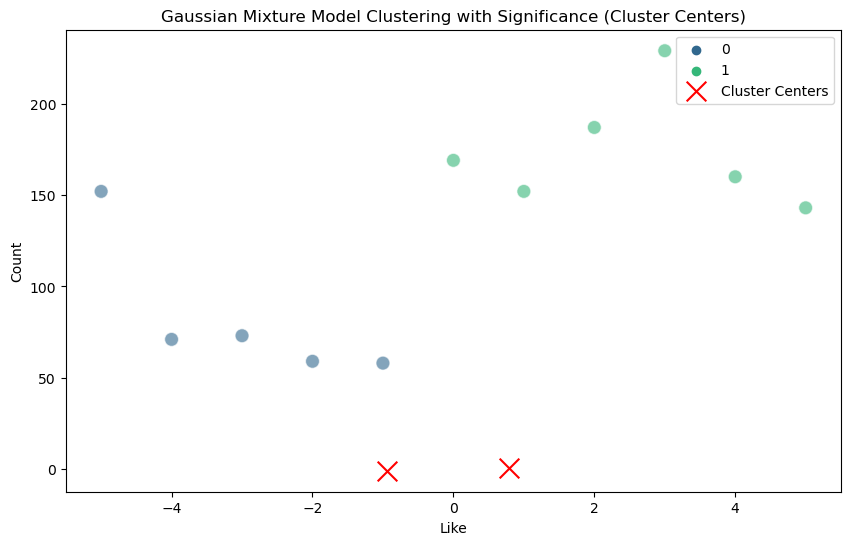

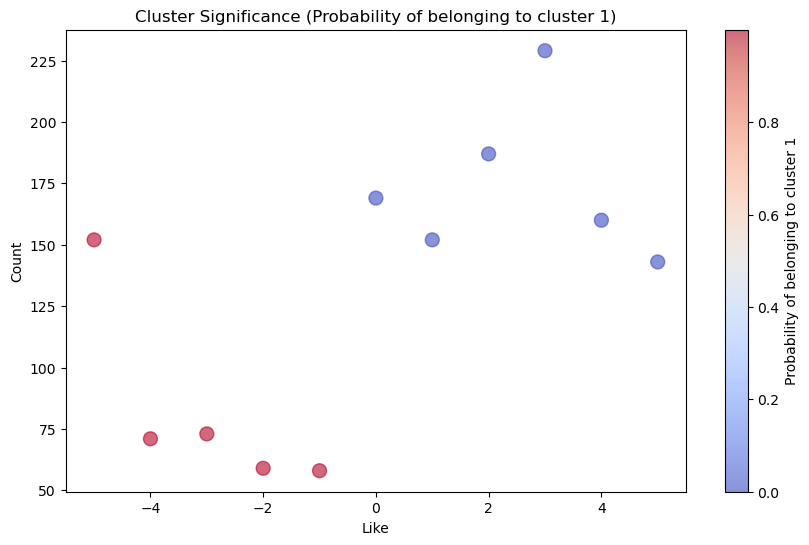

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Sample data (assuming df dataframe)

df = pd.DataFrame(df)

# Convert 'Like' column to numeric
df['Like'] = pd.to_numeric(df['Like'])

# Prepare the data (feature selection or transformations)
X = df[['Like', 'Count']].values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Gaussian Mixture Model (GMM) with 2 clusters
gmm = GaussianMixture(n_components=2, random_state=1234)
gmm.fit(X_scaled)

# Get cluster labels
labels = gmm.predict(X_scaled)

# Plotting the clusters
plt.figure(figsize=(10, 6))

# Plotting the data points
sns.scatterplot(x=df['Like'], y=df['Count'], hue=labels, palette="viridis", s=100, alpha=0.6)

# Plotting the Gaussian mixture centers
centers = gmm.means_
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, label="Cluster Centers")

# Display the plot
plt.title("Gaussian Mixture Model Clustering with Significance (Cluster Centers)")
plt.xlabel("Like")
plt.ylabel("Count")
plt.legend()
plt.show()

# To visualize the "significance", we can use the probabilities of the data points for each cluster
probabilities = gmm.predict_proba(X_scaled)

# You can plot the probability of belonging to the first cluster
plt.figure(figsize=(10, 6))
plt.scatter(df['Like'], df['Count'], c=probabilities[:, 0], cmap='coolwarm', s=100, alpha=0.6)
plt.colorbar(label='Probability of belonging to cluster 1')
plt.title("Cluster Significance (Probability of belonging to cluster 1)")
plt.xlabel("Like")
plt.ylabel("Count")
plt.show()


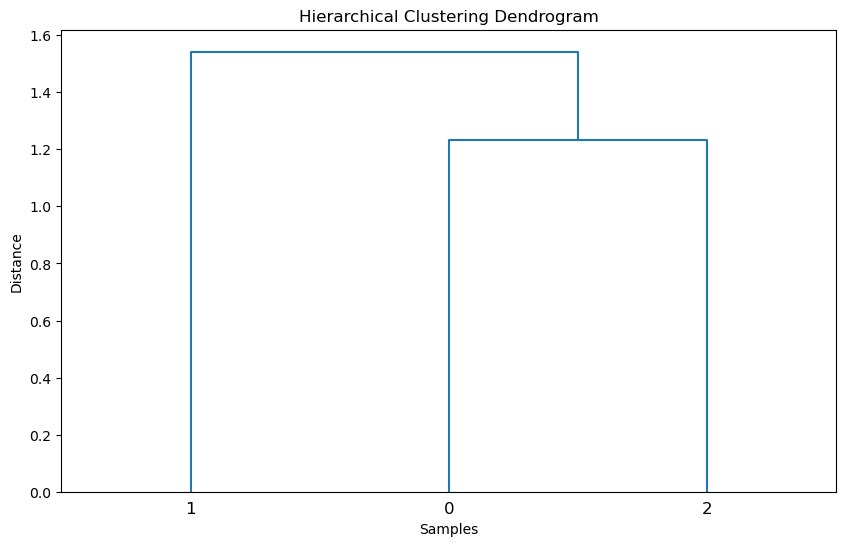

In [60]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Sample data (assuming MD.x dataframe)
# Let's create a sample DataFrame as MD.x
data = {'Feature1': np.random.rand(10), 'Feature2': np.random.rand(10), 'Feature3': np.random.rand(10)}
MD_x = pd.DataFrame(data)

# Transpose the DataFrame (equivalent to t(MD.x) in R)
MD_x_transposed = MD_x.T

# Compute the distance matrix
distance_matrix = sch.distance.pdist(MD_x_transposed)

# Perform hierarchical clustering
MD_vclust = sch.linkage(distance_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
sch.dendrogram(MD_vclust)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


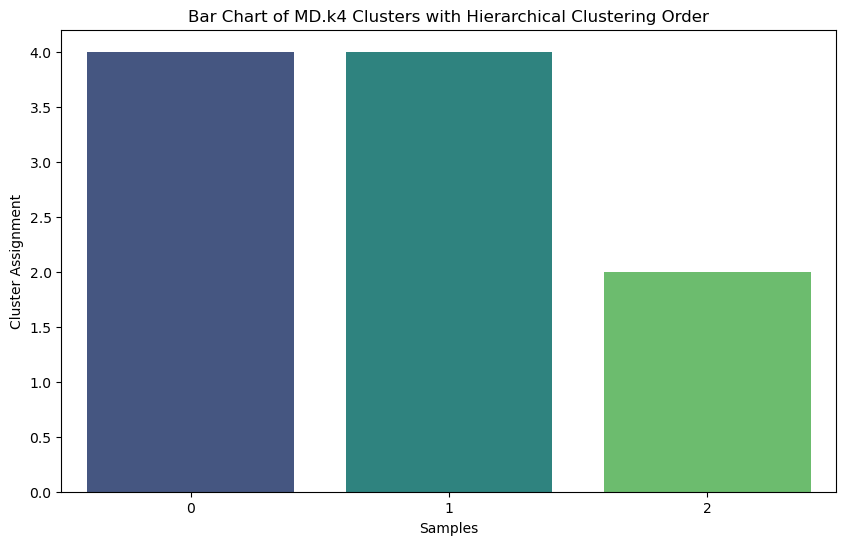

In [61]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (assuming MD.x dataframe)
data = {'Feature1': np.random.rand(10), 'Feature2': np.random.rand(10), 'Feature3': np.random.rand(10)}
MD_x = pd.DataFrame(data)

# Transpose the DataFrame (equivalent to t(MD.x) in R)
MD_x_transposed = MD_x.T

# Compute the distance matrix
distance_matrix = sch.distance.pdist(MD_x_transposed)

# Perform hierarchical clustering
MD_vclust = sch.linkage(distance_matrix, method='ward')

# Get the hierarchical clustering order (equivalent to rev(MD.vclust$order) in R)
cluster_order = sch.dendrogram(MD_vclust, no_plot=True)['leaves'][::-1]

# Assuming MD.k4 is a clustering result, e.g., a list of cluster labels
# Here, we'll create a random cluster assignment for illustration
MD_k4 = np.random.choice([1, 2, 3, 4], size=10)

# Reorder the clusters based on the hierarchical clustering order
ordered_clusters = MD_k4[cluster_order]

# Create a bar chart with the reordered clusters
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(len(ordered_clusters)), y=ordered_clusters, palette="viridis")
plt.title("Bar Chart of MD.k4 Clusters with Hierarchical Clustering Order")
plt.xlabel("Samples")
plt.ylabel("Cluster Assignment")
plt.show()


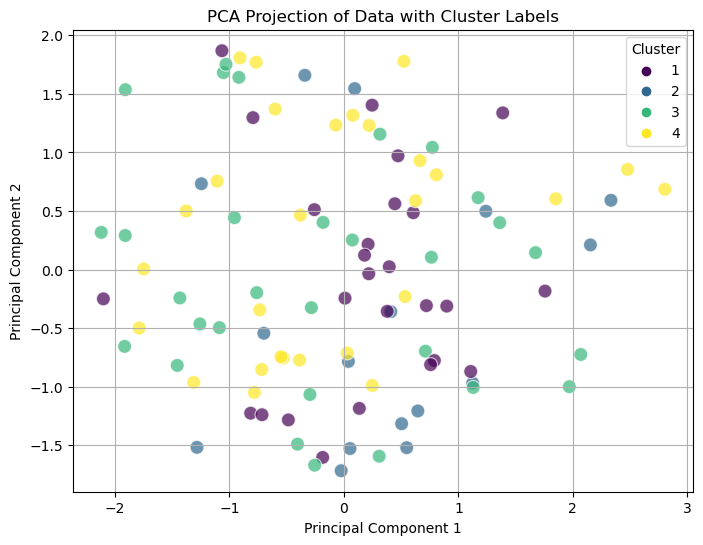

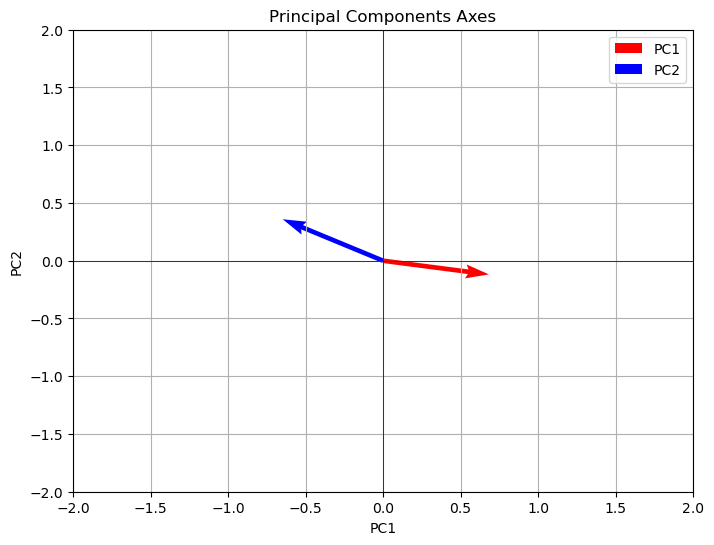

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Sample data (assuming MD.x dataframe)
data = {'Feature1': np.random.rand(100), 'Feature2': np.random.rand(100), 'Feature3': np.random.rand(100)}
MD_x = pd.DataFrame(data)

# Standardize the data
scaler = StandardScaler()
MD_x_scaled = scaler.fit_transform(MD_x)

# Perform PCA
pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD_x_scaled)

# Simulating cluster labels (MD.k4) for plotting
MD_k4 = np.random.choice([1, 2, 3, 4], size=100)

# Plotting the PCA projection with clusters (MD.k4)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=MD_pca[:, 0], y=MD_pca[:, 1], hue=MD_k4, palette="viridis", s=100, alpha=0.7)

# Customize the plot
plt.title("PCA Projection of Data with Cluster Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Plotting the PCA axes (projAxes equivalent in R)
plt.figure(figsize=(8, 6))
plt.quiver(0, 0, pca.components_[0, 0], pca.components_[1, 0], angles='xy', scale_units='xy', scale=1, color='r', label="PC1")
plt.quiver(0, 0, pca.components_[0, 1], pca.components_[1, 1], angles='xy', scale_units='xy', scale=1, color='b', label="PC2")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("Principal Components Axes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True)
plt.legend()
plt.show()


<Figure size 1000x700 with 0 Axes>

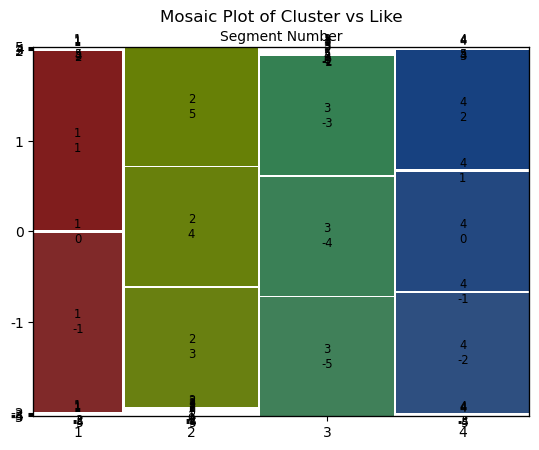

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Sample data (assuming df dataframe)
df = pd.DataFrame(df)

# Convert 'Like' column to numeric
df['Like'] = pd.to_numeric(df['Like'])

# Simulating cluster labels (MD.k4)
MD_k4 = np.random.choice([1, 2, 3, 4], size=11)

# Create a contingency table
contingency_table = pd.crosstab(MD_k4, df['Like'])

# Plot mosaic plot using statsmodels
plt.figure(figsize=(10, 7))
mosaic(contingency_table.stack(), title="Mosaic Plot of Cluster vs Like")

# Adjusting the axis labels and plot
plt.xlabel("Segment Number")
plt.ylabel("Like")
plt.show()


<Figure size 1000x700 with 0 Axes>

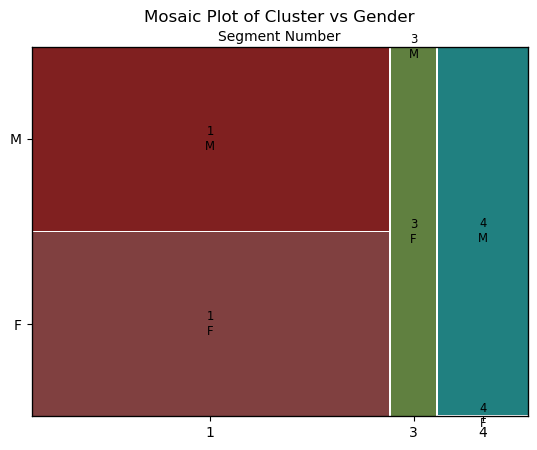

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Sample data (assuming df dataframe with a 'Gender' column)
df = pd.DataFrame(df)

# Convert 'Like' column to numeric
df['Like'] = pd.to_numeric(df['Like'])

# Simulating cluster labels (MD.k4)
MD_k4 = np.random.choice([1, 2, 3, 4], size=11)

# Create a contingency table between cluster and gender
contingency_table = pd.crosstab(MD_k4, df['Gender'])

# Plot mosaic plot using statsmodels
plt.figure(figsize=(10, 7))
mosaic(contingency_table.stack(), title="Mosaic Plot of Cluster vs Gender")

# Adjusting the axis labels and plot
plt.xlabel("Segment Number")
plt.ylabel("Gender")
plt.show()


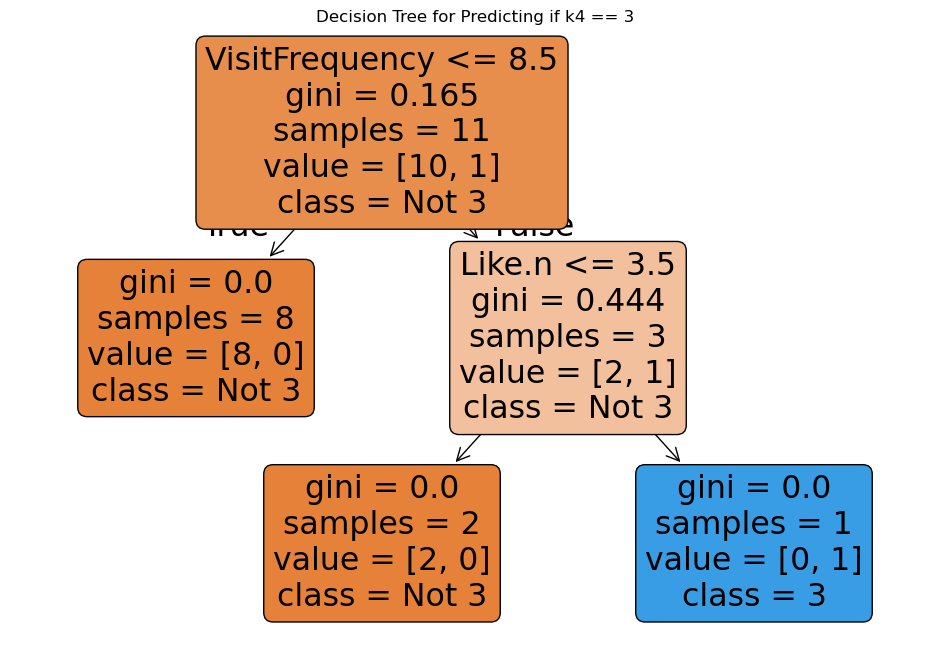

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Sample data (assuming df dataframe with the necessary columns)
df = pd.DataFrame(df)

# Convert 'Like' column to numeric (if needed)
df['Like'] = pd.to_numeric(df['Like'])

# Simulating cluster labels (MD.k4) for classification (as a binary example, Like == 3 or not)
df['k4'] = np.random.choice([1, 2, 3, 4], size=len(df))  # Random cluster assignment

# Prepare data for model (predicting if k4 == 3)
X = df[['Like.n', 'Age', 'VisitFrequency', 'Gender']]
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variable 'Gender' to dummy variables
y = (df['k4'] == 3).astype(int)  # Target variable: whether k4 is 3 or not

# Initialize and train the decision tree classifier
tree = DecisionTreeClassifier(random_state=1234)
tree.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['Not 3', '3'], filled=True, rounded=True)
plt.title("Decision Tree for Predicting if k4 == 3")
plt.show()


In [71]:
import pandas as pd

# Sample data (assuming df dataframe with the necessary columns)
df = pd.DataFrame(df)

# Group by 'k4' and calculate the mean of 'VisitFrequency' for each cluster
visit = df.groupby('k4')['VisitFrequency'].mean()

# Display the result
print(visit)


k4
1    5.0
2    6.0
3    7.0
4    6.0
Name: VisitFrequency, dtype: float64


In [80]:
import pandas as pd

# Sample data (assuming df dataframe with the necessary columns)
df = pd.DataFrame(df)

# Calculate the mean of 'Like.n' grouped by 'k4'
like = df.groupby('k4')['Like.n'].mean()

# Display the result
print(like)


k4
1     7.000000
2    11.000000
3     3.000000
4     5.166667
Name: Like.n, dtype: float64


In [81]:
import pandas as pd

# Sample data (assuming df dataframe with the necessary columns)
df = pd.DataFrame(df)

# Calculate the mean of 'Gender == "Female"' (True = 1, False = 0) grouped by 'k4'
female = df.groupby('k4')['Gender'].apply(lambda x: (x == 'F').mean())

# Display the result
print(female)


k4
1    0.666667
2    0.000000
3    0.000000
4    0.500000
Name: Gender, dtype: float64


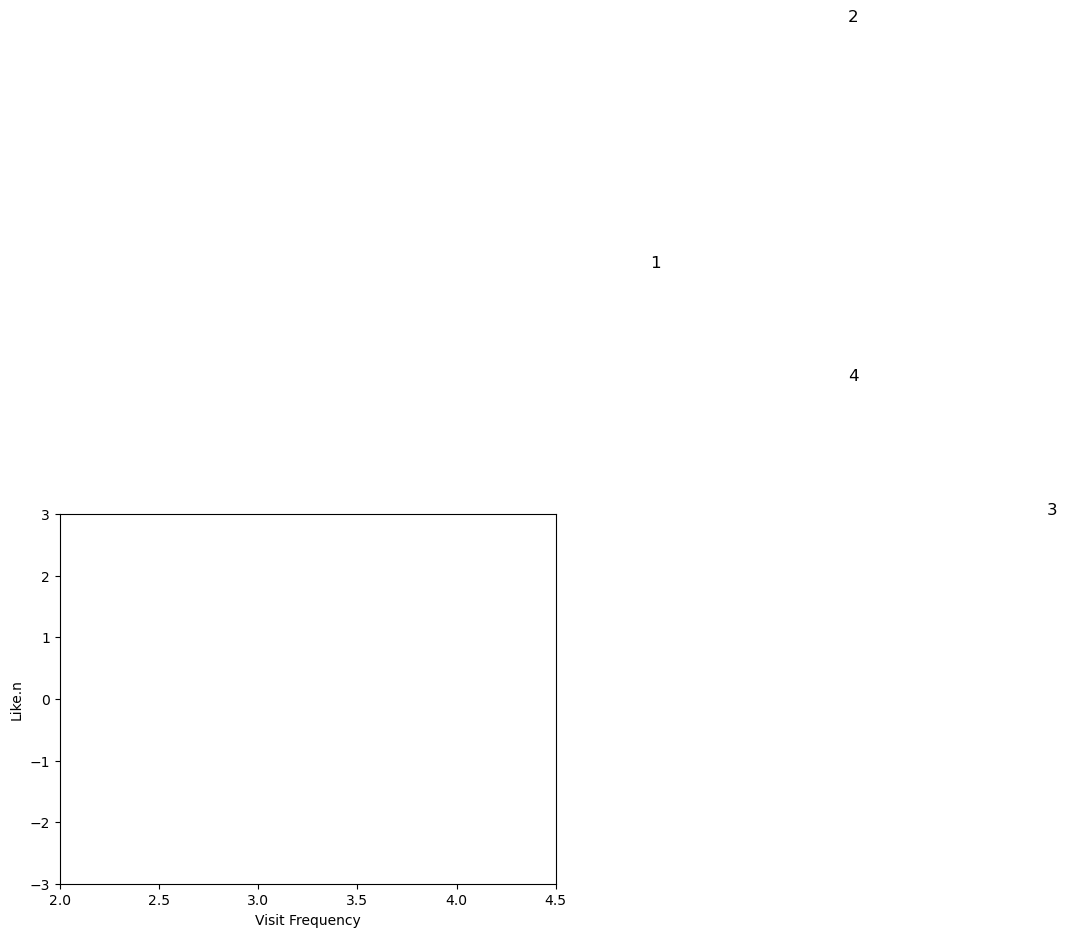

In [83]:
import matplotlib.pyplot as plt

# Assuming 'visit', 'like', and 'female' are calculated as shown previously

# Example data (same as earlier)
visit = [5.0,6.0,7.0,6.0]  # Replace with actual 'visit' values
like = [7.000000, 11.000000,3.000000,5.166667]   # Replace with actual 'like' values
female = [0.666667,0.000000,0.000000,0.500000]  # Replace with actual 'female' values

# Plot visit vs like with cex as the size of points (scaled by female proportion)
plt.scatter(visit, like, s=[10 * f for f in female], c='skyblue', alpha=0.7)

# Annotate the points with 1, 2, 3, 4
for i, txt in enumerate(range(1, 5)):
    plt.text(visit[i], like[i], str(txt), fontsize=12, ha='center')

# Set axis limits
plt.xlim(2, 4.5)
plt.ylim(-3, 3)

# Add labels
plt.xlabel("Visit Frequency")
plt.ylabel("Like.n")

# Show the plot
plt.show()
